In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install konlpy koreanize_matplotlib gensim

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from konlpy.tag import Okt
from gensim.models import Word2Vec
from collections import Counter

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Conv1D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

df=pd.read_csv("./emergency_call_binary_tokens.csv", encoding="utf-8-sig")
df.head()


padding_len = 16
embedding_dim = 1024

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['document'].apply(lambda x: ' '.join(x)))

sequences = tokenizer.texts_to_sequences(df['document'].apply(lambda x: ' '.join(x)))

X = pad_sequences(sequences, maxlen=padding_len, padding='post')

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['label'])
print(f"X shape: {X.shape}, y shape: {y.shape}")


vocab_size = len(tokenizer.word_index) + 1
print(f"vocab_size: {vocab_size}")
print(f"max index in sequences: {np.max(X)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

d1= 128
d2= 64


model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_len),
    GlobalAveragePooling1D(),
    Dense(d1, activation='relu'),
    Dense(d2, activation='relu'),
    Dense(1, activation='sigmoid')
])

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
learning_rate=0.005
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)

X shape: (300, 16), y shape: (300,)
vocab_size: 361
max index in sequences: 360
Epoch 1/30


C:\Users\admin\anaconda3\envs\tf3\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.5908 - loss: 0.6736 - val_accuracy: 0.5417 - val_loss: 0.6838
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7970 - loss: 0.4690 - val_accuracy: 0.7083 - val_loss: 0.7493
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9190 - loss: 0.2398 - val_accuracy: 0.7083 - val_loss: 0.7936
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9728 - loss: 0.0950 - val_accuracy: 0.7292 - val_loss: 0.7866
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9724 - loss: 0.0595 - val_accuracy: 0.7083 - val_loss: 1.4411
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9868 - loss: 0.0458 - val_accuracy: 0.6875 - val_loss: 1.2303
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.6458 - val_loss: 1.7797
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.6458 - val_loss: 1.7691
Epoch 9/30

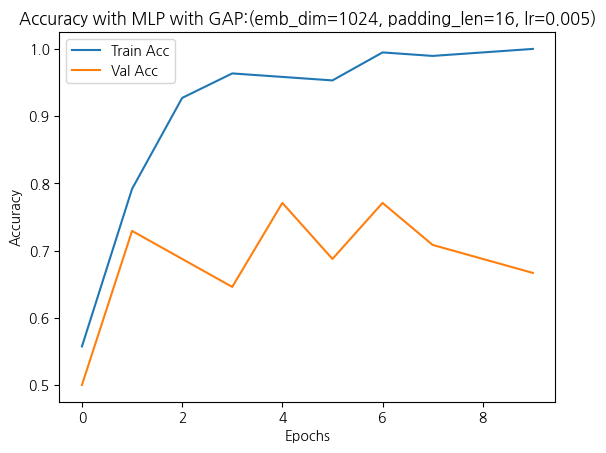

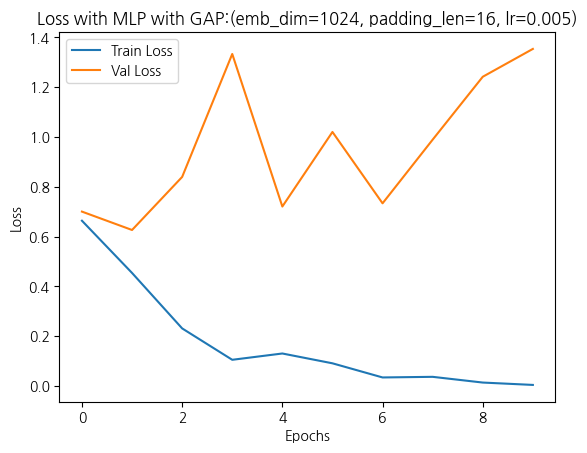

Test Accuracy of MLP with GAP: 0.7167, Loss: 0.6358


In [4]:
choice = 'MLP with GAP'

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title(f"Accuracy with {choice}:(emb_dim={embedding_dim}, padding_len={padding_len}, lr={learning_rate})")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Loss with {choice}:(emb_dim={embedding_dim}, padding_len={padding_len}, lr={learning_rate})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 최종 평가
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy of {choice}: {acc:.4f}, Loss: {loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
=== 분류 성능 보고서 ===
              precision    recall  f1-score   support

          경미       0.69      0.80      0.74        30
          긴급       0.76      0.63      0.69        30

    accuracy                           0.72        60
   macro avg       0.72      0.72      0.71        60
weighted avg       0.72      0.72      0.71        60



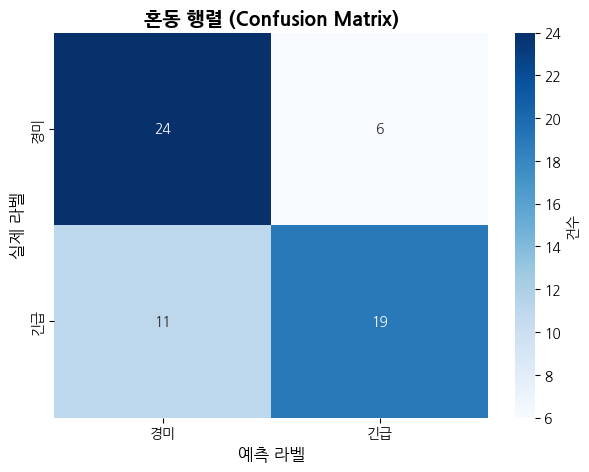

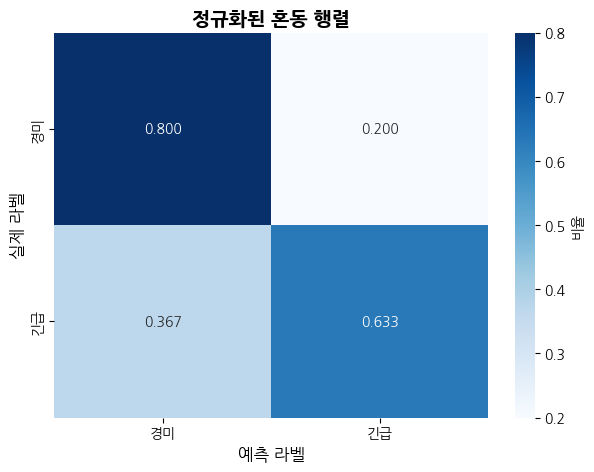

In [5]:

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import koreanize_matplotlib

# Classification Report (한글)
# 예측 수행 (긴급=1, 경미=0 가정)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("=== 분류 성능 보고서 ===")
print(classification_report(y_test, y_pred,
                          target_names=['경미', '긴급']))

# Confusion Matrix 계산 및 시각화
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['경미', '긴급'],
            yticklabels=['경미', '긴급'],
            cbar_kws={'label': '건수'})
plt.title('혼동 행렬 (Confusion Matrix)', fontsize=14, fontweight='bold')
plt.ylabel('실제 라벨', fontsize=12)
plt.xlabel('예측 라벨', fontsize=12)
plt.show()

# 정규화된 Confusion Matrix
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(7, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['경미', '긴급'],
            yticklabels=['경미', '긴급'],
            cbar_kws={'label': '비율'})
plt.title('정규화된 혼동 행렬', fontsize=14, fontweight='bold')
plt.ylabel('실제 라벨', fontsize=12)
plt.xlabel('예측 라벨', fontsize=12)
plt.show()
